##    1. Importing Required Packages

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
# import torchvision.datasets as dset
# import torchvision.transforms as transforms
# import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from copy import deepcopy
import time
from itertools import product
# Set random seed for reproducibility
#manual_seed = 999
manual_seed = 3359 # random.randint(1, 10000)
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

!mkdir results

Random Seed:  3359


## 2. Create Datasets and transform into torch.datasets

Here, we will used contaminated datas, so that we have two source for dataset.

Our dataset will be total 700 data, will be splitted to {data:500, validation:100, test:100}. And 10%(=70) of data will be from other source, called outliner.

Normal source will be linear model where both weight and bias are chosen randomly. 

We will have 3 outliners, each are from linear model, quadratic model, and randomly scattered data.


In [0]:
# Choose weight with tan(theta) where theta is from uniform(-pi/2, pi/2)
weight = np.tan(random.uniform(-np.pi * 5 / 12, np.pi * 5 / 12))
# Choose bias from normal(0, 10)
bias = random.normalvariate(0, 10)

inliner_x = []
inliner_y = []

for i in range(630):
    x = random.uniform(-10, 10)
    y = weight * x + bias + random.normalvariate(0, 0.5)
    inliner_x.append(x)
    inliner_y.append(y)

# Outliner1 : linear model. 
outliner1_weight = np.tan(random.uniform(-np.pi * 5 / 12, np.pi * 5 / 12))
# Choose bias from normal(0, 10)
outliner1_bias = random.normalvariate(0, 10)

outliner1_x = []
outliner1_y = []

for i in range(70):
    x = random.uniform(-10, 10)
    y = outliner1_weight * x + outliner1_bias + random.normalvariate(0, 0.5)
    outliner1_x.append(x)
    outliner1_y.append(y)

# Outliner2 : Quadratic model
outliner2_second = random.uniform(-5, 5)
outliner2_first = random.uniform(-5, 5)
outliner2_const = random.uniform(-5, 5)

outliner2_x = []
outliner2_y = []

for i in range(70):
    x = random.uniform(-10, 10)
    y = outliner2_second * x * x + outliner2_first * x + outliner2_const + random.normalvariate(0, 0.5)
    outliner2_x.append(x)
    outliner2_y.append(y)

# Outliner3 : Randomly scattered
outliner3_x = []
outliner3_y = []

for i in range(70):
    x = random.uniform(-10, 10)
    y = random.uniform(-20, 20)
    outliner3_x.append(x)
    outliner3_y.append(y)

correct = [True for i in range(630)]
wrong = [False for i in range(70)]

ex1_x = inliner_x + outliner1_x
ex1_y = inliner_y + outliner1_y
ex2_x = inliner_x + outliner2_x
ex2_y = inliner_y + outliner2_y
ex3_x = inliner_x + outliner3_x
ex3_y = inliner_y + outliner3_y
labels = correct + wrong

tensor_ex1_x = torch.from_numpy(np.array(ex1_x)).float()
tensor_ex1_y = torch.from_numpy(np.array(ex1_y)).float()
tensor_ex2_x = torch.from_numpy(np.array(ex2_x)).float()
tensor_ex2_y = torch.from_numpy(np.array(ex2_y)).float()
tensor_ex3_x = torch.from_numpy(np.array(ex3_x)).float()
tensor_ex3_y = torch.from_numpy(np.array(ex3_y)).float()
tensor_label = torch.from_numpy(np.array(labels))

dataset_ex1 = torch.utils.data.TensorDataset(tensor_ex1_x, tensor_ex1_y, tensor_label)
dataset_ex2 = torch.utils.data.TensorDataset(tensor_ex2_x, tensor_ex2_y, tensor_label)
dataset_ex3 = torch.utils.data.TensorDataset(tensor_ex3_x, tensor_ex3_y, tensor_label)

trainset_ex1, validset_ex1, testset_ex1 = torch.utils.data.random_split(dataset_ex1, [500, 100, 100]) 
trainset_ex2, validset_ex2, testset_ex2 = torch.utils.data.random_split(dataset_ex2, [500, 100, 100]) 
trainset_ex3, validset_ex3, testset_ex3 = torch.utils.data.random_split(dataset_ex3, [500, 100, 100]) 

partition_ex1 = {'train':trainset_ex1, 'val':validset_ex1, 'test':testset_ex1}
partition_ex2 = {'train':trainset_ex2, 'val':validset_ex2, 'test':testset_ex2}
partition_ex3 = {'train':trainset_ex3, 'val':validset_ex3, 'test':testset_ex3}

### 2-1 Visualize created data

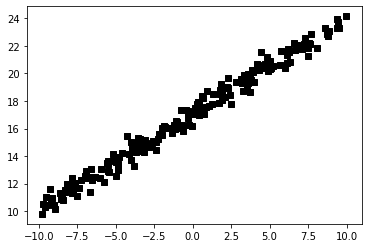

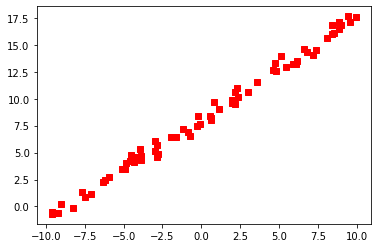

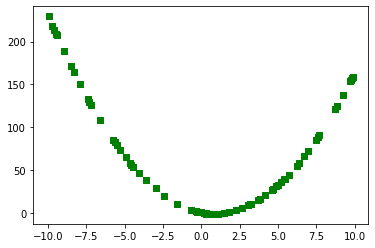

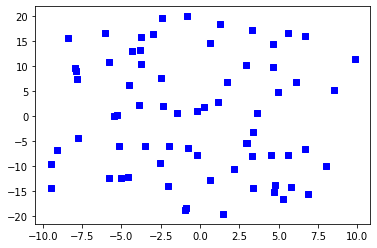

In [3]:
plt.figure(1)

plt.scatter(inliner_x[:200], inliner_y[:200], c="k", marker=",")

plt.figure(2)
plt.scatter(outliner1_x[:200], outliner1_y[:200], c="r", marker=",")
plt.figure(3)
plt.scatter(outliner2_x[:200], outliner2_y[:200], c="g", marker=",")
plt.figure(4)
plt.scatter(outliner3_x[:200], outliner3_y[:200], c="b", marker=",")

plt.show()

## 3. Model

In [4]:
class Linear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Linear, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim, bias=True)
        nn.init.xavier_normal_(self.linear.weight)
        self.linear.bias.data.fill_(.01)

    def forward(self, x):
        return self.linear(x)

# Test model generation
test = Linear(1, 1)
test

Linear(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

## 4. Hyperparameter defining



In [5]:
args = argparse.ArgumentParser().parse_args("")
args.optim = "SGD"
args.epoch = 30
args.lr = 0.01
args.batch_size = 16
args.test_batch_size = 1000
args.in_dim = 1
args.out_dim = 1
args.ex = 1
args.threshold = 1

print(args)

Namespace(batch_size=16, epoch=30, ex=1, in_dim=1, lr=0.01, optim='SGD', out_dim=1, test_batch_size=1000, threshold=1)


## 5. Define train/validate/test function

In [0]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()
    optimizer.zero_grad()

    correct = 0
    total = 0
    counted = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, expects, labels = data
        #print("sizes : ", inputs.size(), expects.size(), labels.size())
        inputs = inputs.view(-1, args.in_dim)
        outputs = net(inputs).view(-1)
        #print("parameters : ", net.linear.weight.data, net.linear.bias.data)
        #print("inputs : ", inputs, inputs.size())
        #print("expects : ", expects, expects.size())
        #print("ouputs : ", outputs, outputs.size())
        #print("labels : ", labels, labels.size())
        
        
        diff = (expects - outputs) ** 2
        #print("diff size : ", diff.size())
        diff_average = args.threshold #(diff.sum() / (len(labels) * 5)).item()
        
        model_inline = (diff <= torch.full_like(diff, diff_average, requires_grad = False))
        
        #print("labels : ", labels.size())
        #print("model_inline : ", model_inline.size())
        cur_correct = (model_inline == labels).sum().item()
        correct += cur_correct
        
        # loss = criterion(outputs, expects)

        loss = torch.min(diff, torch.full_like(diff, diff_average, requires_grad = False)).sum()
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
        counted += len(labels)
        
        correct += (model_inline == labels).sum().item()
        total += len(labels)
        #print(correct, total)

    train_loss = train_loss / counted
    train_acc = correct / total
    return net, train_loss, train_acc

In [0]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            inputs, expects, labels = data
            inputs = inputs.view(-1, args.in_dim)
            outputs = net(inputs).view(-1)

            diff = (expects - outputs) ** 2
            diff_average = args.threshold # (diff.sum() / (len(labels) * 5)).item()

            # loss = criterion(expects, outputs)
            loss = torch.min(diff, torch.full_like(diff, diff_average, requires_grad=False)).sum()
            
            val_loss += loss.item()
            model_inline = (diff <= torch.full_like(diff, diff_average, requires_grad = False))
            correct += (model_inline == labels).sum().item()
            total += len(labels)
            #print("{}, {}".format(correct, total))

        val_loss = val_loss / len(valloader)
        val_acc = correct / total
    return val_loss, val_acc

In [0]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, expects, labels = data
            inputs = inputs.view(-1, args.in_dim)
            outputs = net(inputs).view(-1)

            diff = (expects - outputs).abs()
            diff_average = 100 # (diff.sum() / (len(labels) * 5)).item()
        
            model_inline = (diff <= torch.full_like(diff, diff_average, requires_grad = False))
            correct += (model_inline == labels).sum().item()
            total += len(labels)

        test_acc = correct / total
    return test_acc

In [0]:
def experiment(partition, args):
    net = Linear(1, 1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr = args.lr)

    print(args)
    
    train_losses = list()
    train_accs = list()
    val_losses = list()
    val_accs = list()
    test_accs = list()

    for epoch in range(0, args.epoch):
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()

        if epoch == args.epoch - 1:
            print('SGD Epoch {}, Acc(train/val) : {:2.2f}/{:2.2f}, Loss(train/val): {:2.2f}/{:2.2f}. Took {:2.2f} sec.'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
            print('net : {} * x + {}, data : {} * x + {}'.format(net.linear.weight.data.item(), net.linear.bias.data.item(), weight, bias))
        test_acc = test(net, partition, args)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        test_accs.append(test_acc)

        
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['test_accs'] = test_accs
    result['weight'] = net.linear.weight.data.item()
    result['bias'] = net.linear.weight.data.item()
    
    return vars(args), result

In [0]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)
    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

## 6. Experiment

Experiment will be as follows

1. Dataset will be each three dataset 
    - inliner + outliner1
    - inliner + outliner2
    - inliner + outliner3
2. Model will be 1-1 Linear model with bias. 
3. WIth different metric loss, test the result.

In [11]:
args.exp_name = "exp1_linear_outliner"

for it in product([.1, .01, .001], [1, 2, 4, 8, 16, 32, 64]):
    setattr(args, 'lr', it[0])
    setattr(args, 'threshold', it[1])
    setting, result = experiment(partition_ex1, deepcopy(args))
    save_exp_result(setting, result)

Namespace(batch_size=16, epoch=30, ex=1, exp_name='exp1_linear_outliner', in_dim=1, lr=0.1, optim='SGD', out_dim=1, test_batch_size=1000, threshold=1)
SGD Epoch 29, Acc(train/val) : 0.21/0.08, Loss(train/val): 1.00/100.00. Took 0.17 sec.
net : -24.76636505126953 * x + 11.657882690429688, data : 0.6980979280667304 * x + 17.119882854797993
Namespace(batch_size=16, epoch=30, ex=1, exp_name='exp1_linear_outliner', in_dim=1, lr=0.1, optim='SGD', out_dim=1, test_batch_size=1000, threshold=2)
SGD Epoch 29, Acc(train/val) : 0.21/0.08, Loss(train/val): 2.00/200.00. Took 0.17 sec.
net : -28.154422760009766 * x + 10.415790557861328, data : 0.6980979280667304 * x + 17.119882854797993
Namespace(batch_size=16, epoch=30, ex=1, exp_name='exp1_linear_outliner', in_dim=1, lr=0.1, optim='SGD', out_dim=1, test_batch_size=1000, threshold=4)
SGD Epoch 29, Acc(train/val) : 0.21/0.08, Loss(train/val): 4.00/400.00. Took 0.17 sec.
net : 0.8796416521072388 * x + 0.009999999776482582, data : 0.6980979280667304 * 

In [12]:
args.exp_name = "exp2_quadratic_outliner"

for it in product([.1, .01, .001], [1, 2, 4, 8, 16, 32, 64]):
    setattr(args, 'lr', it[0])
    setattr(args, 'threshold', it[1])
    setting, result = experiment(partition_ex2, deepcopy(args))
    save_exp_result(setting, result)

Namespace(batch_size=16, epoch=30, ex=1, exp_name='exp2_quadratic_outliner', in_dim=1, lr=0.1, optim='SGD', out_dim=1, test_batch_size=1000, threshold=1)
SGD Epoch 29, Acc(train/val) : 0.20/0.10, Loss(train/val): 1.00/99.59. Took 0.17 sec.
net : 44.23971176147461 * x + -11.843575477600098, data : 0.6980979280667304 * x + 17.119882854797993
Namespace(batch_size=16, epoch=30, ex=1, exp_name='exp2_quadratic_outliner', in_dim=1, lr=0.1, optim='SGD', out_dim=1, test_batch_size=1000, threshold=2)
SGD Epoch 29, Acc(train/val) : 0.20/0.09, Loss(train/val): 2.00/200.00. Took 0.18 sec.
net : -46.29300308227539 * x + 6.069036960601807, data : 0.6980979280667304 * x + 17.119882854797993
Namespace(batch_size=16, epoch=30, ex=1, exp_name='exp2_quadratic_outliner', in_dim=1, lr=0.1, optim='SGD', out_dim=1, test_batch_size=1000, threshold=4)
SGD Epoch 29, Acc(train/val) : 0.20/0.09, Loss(train/val): 4.00/400.00. Took 0.17 sec.
net : -48.35530471801758 * x + -8.98132038116455, data : 0.6980979280667304

In [13]:
args.exp_name = "exp3_sparse_outliner"

for it in product([.1, .01, .001], [1, 2, 4, 8, 16, 32, 64]):
    setattr(args, 'lr', it[0])
    setattr(args, 'threshold', it[1])
    setting, result = experiment(partition_ex3, deepcopy(args))
    save_exp_result(setting, result)

Namespace(batch_size=16, epoch=30, ex=1, exp_name='exp3_sparse_outliner', in_dim=1, lr=0.1, optim='SGD', out_dim=1, test_batch_size=1000, threshold=1)
SGD Epoch 29, Acc(train/val) : 0.20/0.11, Loss(train/val): 1.00/99.14. Took 0.18 sec.
net : 23.10774040222168 * x + -15.466322898864746, data : 0.6980979280667304 * x + 17.119882854797993
Namespace(batch_size=16, epoch=30, ex=1, exp_name='exp3_sparse_outliner', in_dim=1, lr=0.1, optim='SGD', out_dim=1, test_batch_size=1000, threshold=2)
SGD Epoch 29, Acc(train/val) : 0.20/0.10, Loss(train/val): 2.00/200.00. Took 0.17 sec.
net : -42.4556884765625 * x + 6.709035396575928, data : 0.6980979280667304 * x + 17.119882854797993
Namespace(batch_size=16, epoch=30, ex=1, exp_name='exp3_sparse_outliner', in_dim=1, lr=0.1, optim='SGD', out_dim=1, test_batch_size=1000, threshold=4)
SGD Epoch 29, Acc(train/val) : 0.20/0.11, Loss(train/val): 4.00/398.04. Took 0.17 sec.
net : 39.63349914550781 * x + -14.155391693115234, data : 0.6980979280667304 * x + 17

## 7. Result VIsualizing

In [14]:

from google.colab import files
datas = """exp1_linear_outliner-1d27f6.json     exp2_quadratic_outliner-6e9213.json
exp1_linear_outliner-28b170.json     exp2_quadratic_outliner-7cddd1.json
exp1_linear_outliner-3615a0.json     exp2_quadratic_outliner-7ecefe.json
exp1_linear_outliner-40b072.json     exp2_quadratic_outliner-801250.json
exp1_linear_outliner-42c67e.json     exp2_quadratic_outliner-88c400.json
exp1_linear_outliner-45cdd8.json     exp2_quadratic_outliner-a34b9f.json
exp1_linear_outliner-4b4f1f.json     exp2_quadratic_outliner-aa94c2.json
exp1_linear_outliner-66659b.json     exp2_quadratic_outliner-af1804.json
exp1_linear_outliner-716288.json     exp2_quadratic_outliner-af482e.json
exp1_linear_outliner-73559a.json     exp2_quadratic_outliner-b0ae83.json
exp1_linear_outliner-84be1e.json     exp3_sparse_outliner-2061b9.json
exp1_linear_outliner-8c0099.json     exp3_sparse_outliner-21f319.json
exp1_linear_outliner-92c500.json     exp3_sparse_outliner-2e8e7a.json
exp1_linear_outliner-9ad6e9.json     exp3_sparse_outliner-34b4d3.json
exp1_linear_outliner-b08976.json     exp3_sparse_outliner-764e9d.json
exp1_linear_outliner-b515b4.json     exp3_sparse_outliner-798ce6.json
exp1_linear_outliner-cdeaf6.json     exp3_sparse_outliner-89cb55.json
exp1_linear_outliner-cf3d54.json     exp3_sparse_outliner-92480b.json
exp1_linear_outliner-d58f61.json     exp3_sparse_outliner-9a1461.json
exp1_linear_outliner-e783d0.json     exp3_sparse_outliner-a07b43.json
exp1_linear_outliner-f95fa7.json     exp3_sparse_outliner-ab66da.json
exp2_quadratic_outliner-07f368.json  exp3_sparse_outliner-b3dcf6.json
exp2_quadratic_outliner-0e763f.json  exp3_sparse_outliner-bb3ef6.json
exp2_quadratic_outliner-1609f4.json  exp3_sparse_outliner-cdac93.json
exp2_quadratic_outliner-1f6dc6.json  exp3_sparse_outliner-ce8cb9.json
exp2_quadratic_outliner-37e636.json  exp3_sparse_outliner-d19535.json
exp2_quadratic_outliner-393258.json  exp3_sparse_outliner-d53ac1.json
exp2_quadratic_outliner-41e25d.json  exp3_sparse_outliner-df0f51.json
exp2_quadratic_outliner-430419.json  exp3_sparse_outliner-e81d0c.json
exp2_quadratic_outliner-5bca19.json  exp3_sparse_outliner-f641fa.json
exp2_quadratic_outliner-6a64e3.json  exp3_sparse_outliner-fb36a8.json
exp2_quadratic_outliner-6e1bc1.json""".split()

for file in datas:
    files.download("results/" + file)

MessageError: ignored

In [0]:
!ls results

In [12]:
b

tensor([1., 2.])